In [1]:
using Pkg
Pkg.activate("MNIST")

  Activating project at `/data/gpfs/projects/punim0638/stephenz/QROT/notebooks/ex_MNIST/MNIST`


In [814]:
using Glob
using CSV
using DataFrames
using Plots
using StatsPlots
using StatsBase
using LaTeXStrings
using ColorSchemes

fnames_all = [Glob.glob("output_wass/mnist_wass_results_N_100_w_0_*.csv"), 
              Glob.glob("output_wass/mnist_wass_results_N_100_w_1_*.csv"),
              Glob.glob("output_wass/mnist_wass_results_N_100_seed_*.csv")]
plots = []
for (fnames, w) in zip(fnames_all, [0, 1, 2])
    df = [CSV.read(f, DataFrame) for f in fnames];
    pal=palette(:Set1_9)
    plt=errorline(df[1].eps_quad, hcat([x.quad for x in df]...), xscale = :log10, marker = :circle, label = "Bistochastic L2 (QOT)", markerstrokewidth = 0, legend = :bottomright, color = pal[1], groupcolor = pal[1], xlabel = L"$\varepsilon$", ylabel = "NMI", size = (300, 250), ylim = (0, 0.8), title = "w = $(w)")
    errorline!(df[1].eps_ent, hcat([x.ent for x in df]...), xscale = :log10, marker = :circle, label = "Bistochastic Ent (EOT)", markerstrokewidth = 0, color = pal[2], groupcolor = pal[2])
    hline!([mean([maximum(x.knn) for x in df]), ], label = L"$k$-NN (best over all $k$)", color = :black)
    push!(plots, plt)
end

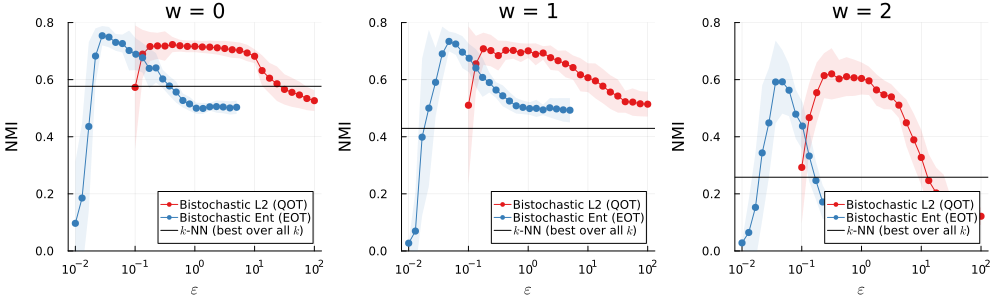

In [815]:
plot(plots...; layout = (1, 3), size = (1000, 300), leftmargin = 5*Plots.mm, bottommargin = 5*Plots.mm)

In [817]:
rank = 25
w = 2
fnames_nys_proj_ent = Glob.glob("output_wass/K_nys_$(rank)_proj_ent_*_w_$(w).csv")
fnames_proj_ent = Glob.glob("output_wass/K_proj_ent_*_w_$(w).csv")
fnames_nys_proj_l2 = Glob.glob("output_wass/K_nys_$(rank)_proj_l2_*_w_$(w).csv")
fnames_proj_l2 = Glob.glob("output_wass/K_proj_l2_*_$(w).csv")
K = CSV.read("output_wass/K_w_$(w).csv", DataFrame);
K_nys = CSV.read("output_wass/K_nys_$(rank)_w_$(w).csv", DataFrame);

In [818]:
using LinearAlgebra
using PyCall
k = 25
sp_la = pyimport_conda("scipy.linalg", "scipy")
get_eigvecs(K, k) = eigen(Hermitian(I-K)).vectors[:, 1:k]
angles_ent = map(((x, y), ) -> sp_la.subspace_angles(get_eigvecs(Array(CSV.read(x, DataFrame)), k), 
                                    get_eigvecs(Array(CSV.read(y, DataFrame)), k)), Iterators.zip(fnames_nys_proj_ent, fnames_proj_ent));
angles_l2 = map(((x, y), ) -> sp_la.subspace_angles(get_eigvecs(Array(CSV.read(x, DataFrame)), k), 
                                    get_eigvecs(Array(CSV.read(y, DataFrame)), k)), Iterators.zip(fnames_nys_proj_l2, fnames_proj_l2));

In [819]:
eps_ent = [parse(Float64, split(splitext(x)[1], "_")[end]) for x in fnames_proj_ent];
eps_l2 = [parse(Float64, split(splitext(x)[1], "_")[end]) for x in fnames_proj_l2];

In [820]:
using LogExpFunctions
perplexity(K) = map(x -> exp(sum(-xlogx.(x))), eachrow(K))
perp_ent = [mean(perplexity(Array(CSV.read(y, DataFrame)))) for y in fnames_proj_ent];
perp_l2 = [mean(perplexity(Array(CSV.read(y, DataFrame)))) for y in fnames_proj_l2];

In [821]:
include("../../src/util.jl")
angles_nys = sp_la.subspace_angles(get_eigvecs(Array(K), k), get_eigvecs(Array(K_nys), k));
perp_nys = mean(perplexity(norm_kernel(Array(K), :row)));

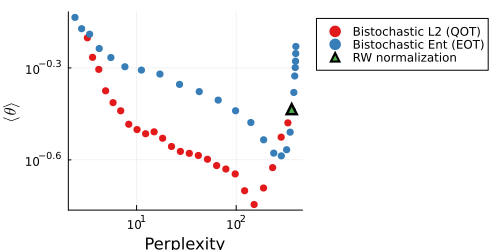

In [822]:
scatter(perp_l2, mean.(angles_l2), xscale = :log10, yscale = :log10, label = "Bistochastic L2 (QOT)", palette = :Set1_9, markerstrokewidth = 0, xlabel = "Perplexity", ylabel = L"$\langle \theta \rangle$", size = (500, 250), legend = :outertopright)
scatter!(perp_ent, mean.(angles_ent), label = "Bistochastic Ent (EOT)", markerstrokewidth = 0)
scatter!([perp_nys,], [mean(angles_nys), ], label = "RW normalization", marker = :^, markerstrokewidth = 5, markersize = 5)